# Swarming test for HTM Univariate

In this notebook we are testing:
1. Swarm over datasets: medium, all data 


In [3]:
import numpy as np
import pandas as pd
import json
import datetime
import matplotlib.pyplot as plt 

# from tqdm import tqdm_notebook
# import time

## Load Data
Load Data and Groundtruth labels:

In [4]:
PATH_relative = 'realKnownCause/machine_temperature_system_failure.csv'

In [5]:
df = pd.read_csv('../data/NAB/' + PATH_relative) #parse_dates=True
with open('../labels/NAB/combined_windows.json') as f:
    labels = json.loads(f.read())

In [6]:
df[0:5]

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [7]:
df.drop([0,1], inplace=True)
df.reset_index(drop=True, inplace=True)
df['value'] = pd.to_numeric(df['value'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d %H:%M:%S")

Groundtruth labels for anomaly

In [8]:
labels[PATH_relative]

[[u'2013-12-10 06:25:00.000000', u'2013-12-12 05:35:00.000000'],
 [u'2013-12-15 17:50:00.000000', u'2013-12-17 17:00:00.000000'],
 [u'2014-01-27 14:20:00.000000', u'2014-01-29 13:30:00.000000'],
 [u'2014-02-07 14:55:00.000000', u'2014-02-09 14:05:00.000000']]

In [9]:
df['labels'] = np.zeros_like(df.value)

# set values within the range = 1
for i in range(len(labels[PATH_relative])):
    df.loc[(df['timestamp'] >= labels[PATH_relative][i][0]) & 
             (df['timestamp'] <= labels[PATH_relative][i][1]), 'labels'] = 1

In [10]:
df[0:5]

,timestamp,value,labels
0,2013-12-02 21:25:00,76.124162,0.0
1,2013-12-02 21:30:00,78.140707,0.0
2,2013-12-02 21:35:00,79.329836,0.0
3,2013-12-02 21:40:00,78.710418,0.0
4,2013-12-02 21:45:00,80.269784,0.0


## SWARM
**Hyperparameter search**

Making use of the *swarm algorithm*, we will find the hyperparmeter gor our HTM model.  
To perform the *swarm*, we need to create a `.json` file feed with informations about our data.  
Once the hyperparameter search is completed, we need to load the best model parameters.

In [11]:
PATH_relative

'realKnownCause/machine_temperature_system_failure.csv'

In [12]:
def create_search_def(data, selectCols, source, predictCol=[], 
                      timestampCol=None, inferenceType='TemporalAnomaly', 
                      iterationCount=-1, swarmSize='medium'):
    """
    Generates the `search_def` dict, to be then converted as `.json`.
    
    Parameters
    ----------
    data: pandas.DataFrame
        Timestamp column if present must be named 'timestamp'.
        Other columns are considered as `float`.
    timestampCol: str 
        If present, name of column containing `datetime` variable.
    selectCols: list of str
        List of column names elegible for swarming.
    predictCol: str
        Name of the column --only 1!-- to be predicted.
    source: str
        `Path_to_file + file.csv` containing our DataFrame.
        Must start from the root of nupic.
    inferenceType: str, default='TemporalMultistep'
    iterationCount: int, default=-1
        Number of value every model iterates on. 
        `-1` iterates over all data in data frame.
    swarmSize: str ('small', 'medium', 'large')
        Default='medium', for debugging suggested 'small'.
                
    Output
    ------
    search_def : dict
        Dictionary version of 'search_def.json'
    
    Notes
    -----
    To understand how to change the default paramaters for `inferenceType`, 
    'iterationCount' and 'swarmSize' consider reading the swarm documentation: 
    'http://nupic.docs.numenta.org/stable/guides/swarming/running.html#the-swarm-description' 

    
    """
    includedFields = []
    
    if timestampCol != None:
        field = {
            "fieldName": timestampCol,
            "fieldType": "datetime",
        }
        includedFields.append(field)

    for i in selectCols:
        field = {
            "fieldName": data[i].name,
            "fieldType": "float",
            "minValue": data[i].min(),
            "maxValue": data[i].max()
        }        
        includedFields.append(field)

    search_def = {
        "includedFields": includedFields,
        "streamDef" : {
            "info": "Experiment",
            "version": 1,
            "streams": [
              {
                "info": "Exp",
                "source": "file://" + source,
                "columns": [
                  "*"
                ]
              }
            ]
          },

        "inferenceArgs" : {
            "predictionSteps": [
              1
            ],
            "predictedField": predictCol
          },
        "inferenceType" : inferenceType,
        "iterationCount" : iterationCount,
        "swarmSize" : swarmSize
    }
    
    return search_def

In [13]:
search_def = create_search_def(df, selectCols=['value'], timestampCol='timestamp', 
                               predictCol='value', 
                               source="ab_experiments/data/NAB/"+PATH_relative)

In [14]:
search_def

{'includedFields': [{'fieldName': 'timestamp', 'fieldType': 'datetime'},
  {'fieldName': 'value',
   'fieldType': 'float',
   'maxValue': 108.5105428,
   'minValue': 2.0847212060000002}],
 'inferenceArgs': {'predictedField': 'value', 'predictionSteps': [1]},
 'inferenceType': 'TemporalAnomaly',
 'iterationCount': -1,
 'streamDef': {'info': 'Experiment',
  'streams': [{'columns': ['*'],
    'info': 'Exp',
    'source': 'file://ab_experiments/data/NAB/realKnownCause/machine_temperature_system_failure.csv'}],
  'version': 1},
 'swarmSize': 'medium'}

In [15]:
def write_search_def_to_file(search_def_dict):
    """
    Write `search_def` dict to `search_def.json`.
    The file will be written in the notebook folder.
    
    Parameters
    ----------
    search_def_dict: dict
        Dictionary as outputed by `create_search_def`
        as indicated in: 
        'http://nupic.docs.numenta.org/stable/guides/swarming/running.html#a-simple-example'
    
    Output
    ----------
    `search_def.json`: `.json` file
        File to perform swarm.
        File located in notebook folder.
    """
    
    with open('search_def.json', 'w') as f:
        json.dump(search_def_dict, f, indent=2, separators=(", ", ": "))

In [16]:
# write_search_def_to_file(search_def)

---
- **Open** original `.csv` in `ab_experiments/data/NAB/realKnownCause/machine_temperature_system_failure.csv` and  
save it as `machine_temperature_system_failure_backup.csv` 
- **Edit header** of `machine_temperature_system_failure_backup.csv` adding lines #2 and #3:
    ```
    timestamp,value
    datetime, float
    T,
    2013-12-02 21:15:00,73.96732207

    ```
- **Move** *search_def.json* and **execute** swarm algorithm:

    ```
    $ mv ab_experiments/notebooks/search_def.json ab_experiments/swarm/NAB/realKnownCaus/machine_temperature_failure

    $ python scripts/run_swarm.py ab_experiments/swarm/NAB/realKnownCause/machine_temperature_failure/search_def.json --overwrite --maxWorkers=4
    ```

---

**Swarm RESULTS**  
The best hyperparameter are stored in `ab_experiments/swarm/NAB/realKnownCause/machine_temperature_failure/swarm_medium_allData/model_0`  
in **model_params.py**

## HTM Model

**Load** MODEL_PARAMS:

In [17]:
MODEL_PARAMS = {'aggregationInfo': {'days': 0,
                     'fields': [],
                     'hours': 0,
                     'microseconds': 0,
                     'milliseconds': 0,
                     'minutes': 0,
                     'months': 0,
                     'seconds': 0,
                     'weeks': 0,
                     'years': 0},
 'model': 'HTMPrediction',
 'modelParams': {'anomalyParams': {u'anomalyCacheRecords': None,
                                   u'autoDetectThreshold': None,
                                   u'autoDetectWaitRecords': None},
                 'clParams': {'alpha': 0.03199623347319286,
                              'regionName': 'SDRClassifierRegion',
                              'steps': '1',
                              'verbosity': 0},
                 'inferenceType': 'TemporalAnomaly',
                 'sensorParams': {'encoders': {u'timestamp_dayOfWeek': None,
                                               u'timestamp_timeOfDay': None,
                                               u'timestamp_weekend': {'fieldname': 'timestamp',
                                                                      'name': 'timestamp',
                                                                      'type': 'DateEncoder',
                                                                      'weekend': (21,
                                                                                  1)},
                                               u'value': {'clipInput': True,
                                                          'fieldname': 'value',
                                                          'maxval': 108.5105428,
                                                          'minval': 2.084721206,
                                                          'n': 29,
                                                          'name': 'value',
                                                          'type': 'ScalarEncoder',
                                                          'w': 21}},
                                  'sensorAutoReset': None,
                                  'verbosity': 0},
                 'spEnable': True,
                 'spParams': {'boostStrength': 0.0,
                              'columnCount': 2048,
                              'globalInhibition': 1,
                              'inputWidth': 0,
                              'numActiveColumnsPerInhArea': 40,
                              'potentialPct': 0.8,
                              'seed': 1956,
                              'spVerbosity': 0,
                              'spatialImp': 'cpp',
                              'synPermActiveInc': 0.05,
                              'synPermConnected': 0.1,
                              'synPermInactiveDec': 0.06265155177806427},
                 'tmEnable': True,
                 'tmParams': {'activationThreshold': 12,
                              'cellsPerColumn': 32,
                              'columnCount': 2048,
                              'globalDecay': 0.0,
                              'initialPerm': 0.21,
                              'inputWidth': 2048,
                              'maxAge': 0,
                              'maxSegmentsPerCell': 128,
                              'maxSynapsesPerSegment': 32,
                              'minThreshold': 10,
                              'newSynapseCount': 20,
                              'outputType': 'normal',
                              'pamLength': 2,
                              'permanenceDec': 0.1,
                              'permanenceInc': 0.1,
                              'seed': 1960,
                              'temporalImp': 'cpp',
                              'verbosity': 0},
                 'trainSPNetOnlyIfRequested': False},
 'predictAheadTime': None,
 'version': 1}

In [18]:
data = df.to_dict(orient='records')
data[0:5]

[{'labels': 0.0,
  'timestamp': Timestamp('2013-12-02 21:25:00'),
  'value': 76.12416182},
 {'labels': 0.0,
  'timestamp': Timestamp('2013-12-02 21:30:00'),
  'value': 78.14070732},
 {'labels': 0.0,
  'timestamp': Timestamp('2013-12-02 21:35:00'),
  'value': 79.32983574},
 {'labels': 0.0,
  'timestamp': Timestamp('2013-12-02 21:40:00'),
  'value': 78.71041827},
 {'labels': 0.0,
  'timestamp': Timestamp('2013-12-02 21:45:00'),
  'value': 80.26978421}]

### Encoder

Best Parameters:

In [19]:
MODEL_PARAMS['modelParams']['sensorParams']

{'encoders': {u'timestamp_dayOfWeek': None,
  u'timestamp_timeOfDay': None,
  u'timestamp_weekend': {'fieldname': 'timestamp',
   'name': 'timestamp',
   'type': 'DateEncoder',
   'weekend': (21, 1)},
  u'value': {'clipInput': True,
   'fieldname': 'value',
   'maxval': 108.5105428,
   'minval': 2.084721206,
   'n': 29,
   'name': 'value',
   'type': 'ScalarEncoder',
   'w': 21}},
 'sensorAutoReset': None,
 'verbosity': 0}

In [20]:
for k,v in MODEL_PARAMS['modelParams']['sensorParams']['encoders'].items():
    if v != None:
        print k, v, "\n"
    else: 
        print str(0), "\n" 

timestamp_weekend {'type': 'DateEncoder', 'fieldname': 'timestamp', 'name': 'timestamp', 'weekend': (21, 1)} 

0 

value {'maxval': 108.5105428, 'fieldname': 'value', 'name': 'value', 'w': 21, 'clipInput': True, 'minval': 2.084721206, 'type': 'ScalarEncoder', 'n': 29} 

0 



We need to build: 
- 1x 'DateEncoder' which encodes the field `timestamp`
- 1x 'ScalarEncoder' which encodes the field `value`

In [21]:
def remove_dict_key(d, keys):
    new_d = dict(d)
    for i in keys: 
        del new_d[i]
    return new_d

In [22]:
timestamp_weekend = remove_dict_key(MODEL_PARAMS['modelParams']['sensorParams']['encoders'].values()[0], 
                                    keys=['type','fieldname'])
value = remove_dict_key(MODEL_PARAMS['modelParams']['sensorParams']['encoders'].values()[2], 
                        keys=['type','fieldname'])

In [23]:
#from nupic.encoders.random_distributed_scalar import RandomDistributedScalarEncoder
from nupic.encoders.scalar import ScalarEncoder

In [24]:
vEnc = ScalarEncoder(**value)
#vEnc = ScalarEncoder(resolution=0.1, w=21, minval=60, maxval=100)
print "Parameters: ", value
print str(data[0]['value']) + " = ", vEnc.encode(data[0]['value'])
print str(data[1]['value']) + " = ", vEnc.encode(data[1]['value'])

Parameters:  {'maxval': 108.5105428, 'name': 'value', 'clipInput': True, 'minval': 2.084721206, 'n': 29, 'w': 21}
76.12416182 =  [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
78.14070732 =  [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]


In [25]:
enc = vEnc.encode(75.123)
print(enc)
vEnc.decode(enc)

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]


({'value': ([[68.600859702249991, 68.600859702249991]], '68.60')}, ['value'])

The scalar encoder proposed by *swarm* is extremely rough.  
In timestamp, *swarm* suggestede **weekend** to be a relevant feature.

In [26]:
import datetime
from nupic.encoders.date import DateEncoder

In [27]:
dEnc = DateEncoder(**timestamp_weekend) 

print "Parameters: ", timestamp_weekend

# tsObs1 = datetime.datetime.strptime(data[0]['timestamp'], "%Y-%m-%d %H:%M:%S")
print "TimeStamp-obs0 = ", dEnc.encode(data[0]['timestamp'])
print "TimeStamp-obs1 = ", dEnc.encode(data[1]['timestamp'])

Parameters:  {'name': 'timestamp', 'weekend': (21, 1)}
TimeStamp-obs0 =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
TimeStamp-obs1 =  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


In [28]:
data[0]

{'labels': 0.0,
 'timestamp': Timestamp('2013-12-02 21:25:00'),
 'value': 76.12416182}

In [29]:
obs = []
inputVal = []
inputTs = []
label = []
inputSDRval = []
inputSDRts = []
inputSDR = []  # main
inputTsIdx = [0, len(dEnc.encode(data[0]['timestamp'])) - 1]
inputValIdx = [len(dEnc.encode(data[0]['timestamp'])), 
               len(dEnc.encode(data[0]['timestamp'])) + len(vEnc.encode(data[1]['value'])) - 1]

for i in xrange(len(data)):
    obs.append(i)
    inputTs.append(data[i]['timestamp'])  
    inputVal.append(data[i]['value'])   
    label.append(data[i]['labels'])
    inputSDRts.append(dEnc.encode(data[i]['timestamp']))
    inputSDRval.append(vEnc.encode(data[i]['value']))
    inputSDR.append(np.hstack((inputSDRts[i], inputSDRval[i])))  # combine the 2 ancoders in 1 enoder 
    
# send everything to dict    
data = pd.DataFrame({'inputVal':inputVal, 'inputTs':inputTs, 'label': label,
                      'inputSDR':inputSDR, 'inputSDRval':inputSDRval, 'inputSDRts':inputSDRts, 
                      #'inputValIdx1':inputValIdx1, 'inputVaIdx2':inputValIdx2
                     }, index=obs).to_dict(orient='records')

In [30]:
print "len(inputSDR): ", len(data[0]['inputSDR'])
print data[0]
print len(data)

len(inputSDR):  71
{'inputSDR': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0], dtype=uint8), 'label': 0.0, 'inputVal': 76.12416182, 'inputTs': Timestamp('2013-12-02 21:25:00'), 'inputSDRts': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8), 'inputSDRval': array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0], dtype=uint8)}
22693


# Spatial Pooler
[link to wiki](http://nupic.docs.numenta.org/1.0.3/api/algorithms/spatial-pooling.html#nupic.algorithms.spatial_pooler.SpatialPooler)

Load `MODEL_PARAMS` fors SP:

In [31]:
from nupic.algorithms.spatial_pooler import SpatialPooler

In [32]:
MODEL_PARAMS['modelParams']['spParams']

{'boostStrength': 0.0,
 'columnCount': 2048,
 'globalInhibition': 1,
 'inputWidth': 0,
 'numActiveColumnsPerInhArea': 40,
 'potentialPct': 0.8,
 'seed': 1956,
 'spVerbosity': 0,
 'spatialImp': 'cpp',
 'synPermActiveInc': 0.05,
 'synPermConnected': 0.1,
 'synPermInactiveDec': 0.06265155177806427}

In [33]:
selectedSPparams = {
    'boostStrength': 0.0,
    #'columnCount': 2048,
    'globalInhibition': 1,
    #'inputWidth': 0,
    'numActiveColumnsPerInhArea': 40,
    'potentialPct': 0.8,
    'seed': 1956,
    'spVerbosity': 0,
    #'spatialImp': 'cpp',
    'synPermActiveInc': 0.05,
    'synPermConnected': 0.1,
    'synPermInactiveDec': 0.06265155177806427,
    ### Changes
    'inputDimensions': (len(data[0]['inputSDR']), ),
    'columnDimensions': MODEL_PARAMS['modelParams']['spParams']['columnCount'], 
}

In [34]:
# Init SP
sp = SpatialPooler(**selectedSPparams)

In [35]:
# Print SP

cols = []
connections = []

for col in xrange(sp.getColumnDimensions()):
    connected = np.zeros(len(data[0]['inputSDR']), dtype="int")
    sp.getConnectedSynapses(col, connected)
    cols.append(col)
    connections.append(connected)

spSDR = dict(zip(cols, connections))

In [36]:
print "SP Shape:" + str(len(spSDR)) + "; " + str(len(spSDR[0]))

SP Shape:2048; 71


The active bits (min-columns) are set by calculating the *overlapping score* with the input vector.  
*Overalpping score* = `inputSDR` * `spSDR\[column]`

In [37]:
def idx_active_cols(inputArr):
    """
    This function takes an 1d or nd-array and returns a 1d-array with the index for ACTIVE bits/columns: 
    
    Parameters
    ----------
    inputArr:   np.array (1d or nD)
            
    Output
    ------
    tmActiveColsIdx: 1d np.arraz
        Array with index of active cols.
        
    """
    #tmObject.reshape(tmObject.numberOfCols, tm.cellsPerColumn)
    activeColsVec = []  # initialize vector

    for i in range(inputArr.shape[0]):
        # assign 1 if any 1 (active cell) in the column,
        # 0 otherwise
        if np.any(inputArr[i]>0):
        # if np.any(tm.compute(spSDR[track[3]['sp_active']], enableLearn=True, enableInference=True).reshape(256, 3)[i]>0):
            activeColsVec.append(1)
        else:
            activeColsVec.append(0)
    # return index of active Columns        
    tmActiveColsIdx = np.flatnonzero(np.array(activeColsVec))
    return tmActiveColsIdx

`Compute` returns the to 40 active cols, as defined in:  
`MODEL_PARAMS['modelParams']['spParams']['numActiveColumnsPerInhArea']=40`.

In [38]:
for i in xrange(len(data)):
    output = np.zeros(sp.getColumnDimensions(), dtype="int")
    sp.compute(data[i]['inputSDR'], learn=False, activeArray=output)
    data[i]['sp_active'] = idx_active_cols(output) #save to dict
    
#     print "obs" + str(i) + ", Active col: ", str(output)

In [39]:
for _ in xrange(5):
    print "obs" + str(i)
    print "Active col: ", data[i]['sp_active']

obs22692
Active col:  [   7   17   31   72   77   95  145  162  164  178  185  227  231 1703 1746
 1794 1855 1867 1868 1919 1934 1937 1942 1951 1958 1962 1975 1986 1988 1991
 2002 2003 2005 2012 2019 2026 2032 2039 2044 2047]
obs22692
Active col:  [   7   17   31   72   77   95  145  162  164  178  185  227  231 1703 1746
 1794 1855 1867 1868 1919 1934 1937 1942 1951 1958 1962 1975 1986 1988 1991
 2002 2003 2005 2012 2019 2026 2032 2039 2044 2047]
obs22692
Active col:  [   7   17   31   72   77   95  145  162  164  178  185  227  231 1703 1746
 1794 1855 1867 1868 1919 1934 1937 1942 1951 1958 1962 1975 1986 1988 1991
 2002 2003 2005 2012 2019 2026 2032 2039 2044 2047]
obs22692
Active col:  [   7   17   31   72   77   95  145  162  164  178  185  227  231 1703 1746
 1794 1855 1867 1868 1919 1934 1937 1942 1951 1958 1962 1975 1986 1988 1991
 2002 2003 2005 2012 2019 2026 2032 2039 2044 2047]
obs22692
Active col:  [   7   17   31   72   77   95  145  162  164  178  185  227  231 1703 174

In [40]:
# Permanence
# permanence = []

# for i in xrange(sp.getColumnDimensions()):
#     p = []
#     sp.getPermanence(i, p)
#     permanence.append(np.array(p))

# permanence[0]

For `Permanence > Threshold` we have a connection to the *inputSDR*.

Summarizing SP:

In [41]:
entry = 0

print "inputSDR: ", data[entry]['inputSDR']
print "SDR active bits", idx_active_cols(data[entry]['inputSDR'])
print "SP active col: ", data[entry]['sp_active']
print "\n", "------------"

for i in data[entry]['sp_active']:
    print "SP active col: " + str(i) + "; \tOverlappin bits: " + str(sum(spSDR[i] * data[entry]['inputSDR']))

#print "Pemanence winning col: ", permanence[track[0]['sp_active']]

inputSDR:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
SDR active bits [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
SP active col:  [   7   17   95  145  147  162  164  178  185  189  227  231 1703 1746 1753
 1775 1794 1797 1818 1822 1855 1864 1867 1937 1942 1951 1958 1962 1975 1986
 1988 1991 2003 2005 2012 2019 2032 2039 2044 2047]

------------
SP active col: 7; 	Overlappin bits: 17
SP active col: 17; 	Overlappin bits: 17
SP active col: 95; 	Overlappin bits: 17
SP active col: 145; 	Overlappin bits: 19
SP active col: 147; 	Overlappin bits: 16
SP active col: 162; 	Overlappin bits: 17
SP active col: 164; 	Overlappin bits: 17
SP active col: 178; 	Overlappin bits: 16
SP active col: 185; 	Overlappin bits: 17
SP active col: 189; 	Overlappin bits: 16
SP active col: 227; 	Overlappin bits: 17
SP active col: 231

# Temporal Pooler

[link to wiki](http://nupic.docs.numenta.org/1.0.3/api/algorithms/sequence-memory.html#nupic.algorithms.backtracking_tm_cpp.BacktrackingTMCPP)

Load `MODEL_PARAMS` fors TM:

In [42]:
MODEL_PARAMS['modelParams']['tmParams']

{'activationThreshold': 12,
 'cellsPerColumn': 32,
 'columnCount': 2048,
 'globalDecay': 0.0,
 'initialPerm': 0.21,
 'inputWidth': 2048,
 'maxAge': 0,
 'maxSegmentsPerCell': 128,
 'maxSynapsesPerSegment': 32,
 'minThreshold': 10,
 'newSynapseCount': 20,
 'outputType': 'normal',
 'pamLength': 2,
 'permanenceDec': 0.1,
 'permanenceInc': 0.1,
 'seed': 1960,
 'temporalImp': 'cpp',
 'verbosity': 0}

In [43]:
selectedTMparams = { 
    'activationThreshold': 12,
    'cellsPerColumn': 32,
    #'columnCount': 2048,
    'globalDecay': 0.0,
    'initialPerm': 0.21,
    #'inputWidth': 2048,
    'maxAge': 0,
    'maxSegmentsPerCell': 128,
    'maxSynapsesPerSegment': 32,
    'minThreshold': 10,
    'newSynapseCount': 20,
    'outputType': 'normal',
    'pamLength': 2,
    'permanenceDec': 0.1,
    'permanenceInc': 0.1,
    'seed': 1960,
    #'temporalImp': 'cpp',
    'verbosity': 0,
    ### Changes
    'numberOfCols': MODEL_PARAMS['modelParams']['tmParams']['columnCount'],
    }

In [44]:
from nupic.algorithms.backtracking_tm import BacktrackingTM

To better understand the example we suggest to set `verbosity=5`

In [45]:
# init TM
tm = BacktrackingTM(**selectedTMparams)

For every input, send the ACTIVE_sp_columns to TM as 0/1 vector

In [46]:
for i in xrange(len(data)): #len(track)
    # for every input, select the 'sp_active' col and get active bit in very col  
    sp4tm = [spSDR.get(sp) for sp in data[i]['sp_active']]
    # stack all the arrays in matrix and sum to see overlap 
    sp4tm = sum(np.array(sp4tm))
    # if overlap 1 send active cols aove 
    sp4tm[sp4tm>0] = 1
    
    # send the vector with the SP active cols to TM
    data[i]['sp4tm'] = sp4tm

In [47]:
# # Step 3: send the  input to the temporal memory for learning

# # Send each input in the sequence in order
# for i in xrange(len(track[:3000])):
    
#     # The compute method performs one step of learning and/or inference. Note:
#     # here we just perform learning but you can perform prediction/inference and
#     # learning in the same step if you want (online learning).
#     tm.compute(track[i]['sp4tm'], enableLearn=True, enableInference=True)
#     # This function prints the segments associated with every cell.$$$$
#     # If you really want to understand the TP, uncomment this line. By following
#     # every step you can get an excellent understanding for exactly how the TP
#     # learns.
#     #tm.printCells()

Use the first 3000 entries to learn, test on the rest:

## Anomaly Score

[link](http://nupic.docs.numenta.org/stable/guides/anomaly-detection.html)

The algorithm for the anomaly score is as follows:  

AS = |A_(t) - (P_(t-1) cross A_(t))|  / |A_(t)|  

A_(t):   Predicted columns at time t  
P_(t-1): Active columns at time t

**Note**: Here, a “predicted column” is a column with a non-zero confidence value. This is not exactly the same as having a cell in the predicted state. For more information, refer the “predicted cells vs. confidences” section below.  

...to compute the confidences for a cell, the Temporal Pooler uses the soft match count (the number of active synapses, regardless of the permanence values). Therefore, the set of columns with non-zero confidences will always be a superset of the columns containing predicted cells.

In [48]:
def computeRawAnomalyScore(activeColumns, prevPredictedColumns):
  """Computes the raw anomaly score.

  The raw anomaly score is the fraction of active columns not predicted.

  :param activeColumns: array of active column indices
  :param prevPredictedColumns: array of columns indices predicted in prev step
  :returns: anomcaly score 0..1 (float)
  """
  nActiveColumns = len(activeColumns)
  if nActiveColumns > 0:
    # Test whether each element of a 1-D array is also present in a second
    # array. Sum to get the total # of columns that are active and were
    # predicted.
    score = np.in1d(activeColumns, prevPredictedColumns).sum()
    # Get the percent of active columns that were NOT predicted, that is
    # our anomaly score.
    score = (nActiveColumns - score) / float(nActiveColumns)
  else:
    # There are no active columns.
    score = 0.0

  return score

In [49]:
# Utility routine for printing the input vector
def formatRow(x):
    s = ''
    for c in range(len(x)):
        if c > 0 and c % 10 == 0:
            s += ' '
        s += str(x[c])
    s += ' '
    return s

## Anomaly Likelihood

``` 
from nupic.algorithms.anomaly_likelihood import AnomalyLikelihood

class AnomalyLikelihood(claLearningPeriod=None,
                       learningPeriod=288,
                       estimationSamples=100,
                       historicWindowSize=8640,
                       reestimationPeriod=100)):

    NOTE: Anomaly likelihood scores are reported at a flat 0.5 for
    learningPeriod + estimationSamples iterations.

    claLearningPeriod and learningPeriod are specifying the same variable,
    although claLearningPeriod is a deprecated name for it.

    :param learningPeriod: (claLearningPeriod: deprecated) - (int) the number of
      iterations required for the algorithm to learn the basic patterns in the
      dataset and for the anomaly score to 'settle down'. The default is based
      on empirical observations but in reality this could be larger for more
      complex domains. The downside if this is too large is that real anomalies
      might get ignored and not flagged.

    :param estimationSamples: (int) the number of reasonable anomaly scores
      required for the initial estimate of the Gaussian. The default of 100
      records is reasonable - we just need sufficient samples to get a decent
      estimate for the Gaussian. It's unlikely you will need to tune this since
      the Gaussian is re-estimated every 10 iterations by default.

    :param historicWindowSize: (int) size of sliding window of historical
      data points to maintain for periodic reestimation of the Gaussian. Note:
      the default of 8640 is based on a month's worth of history at 5-minute
      intervals.

    :param reestimationPeriod: (int) how often we re-estimate the Gaussian
      distribution. The ideal is to re-estimate every iteration but this is a
      performance hit. In general the system is not very sensitive to this
      number as long as it is small relative to the total number of records
      processed.
    ```

In [50]:
from nupic.algorithms.anomaly_likelihood import AnomalyLikelihood

In [51]:
anomalyLikelihood = AnomalyLikelihood()

# for i in xrange(100):  # len(data)
#     # Compute the Anomaly Likelihood
#     likelihood = anomalyLikelihood.anomalyProbability(data[i]['inputVal'], data[i]['AnomalyScore'], data[i]['inputTs'])
#     #likelihood = anomalyLikelihood.anomalyProbability(inputData["value"], anomalyScore, inputData["dttm"])
#     logLikelihood = anomalyLikelihood.computeLogLikelihood(likelihood)
#     data[i]['lh'] = likelihood    
#     data[i]['logLH'] = likelihood
#     #if likelihood > 0.9999:
#         #print "Anomaly detected:", track[i]['inputVal'], track[i]['inputTs'], likelihood
    

## Run Experiment

In [52]:
# Step 4: send the same sequence of vectors and look at predictions made by
# temporal memory


for i in xrange(len(data)):  # len(data) 
#     print "\n\n--------" + str(i) + "-----------"
#     print "Raw input vector\n",formatRow(track[i]['sp4tm'])

    # Send each vector to the TP, with learning turned off
    tm.compute(data[i]['sp4tm'], enableLearn=True, enableInference=True)

    # This method prints out the active state of each cell followed by the
    # predicted state of each cell. For convenience the cells are grouped
    # 10 at a time. When there are multiple cells per column the printout
    # is arranged so the cells in a column are stacked together
    #
    # What you should notice is that the columns where active state is 1
    # represent the SDR for the current input pattern and the columns where
    # predicted state is 1 represent the SDR for the next expected pattern
#     print "\nAll the active and predicted cells:"
#     tm.printStates(printPrevious=False, printLearnState=False)

    # tm.getPredictedState() gets the predicted cells.
    # predictedCells[c][i] represents the state of the i'th cell in the c'th
    # column. To see if a column is predicted, we can simply take the OR
    # across all the cells in that column. In numpy we can do this by taking
    # the max along axis 1.
#     print "\n\nThe following columns are predicted by the temporal memory. This"
#     print "should correspond to columns in the *next* item in the sequence."
#     predictedCells = tm.getPredictedState()
#     print formatRow(predictedCells.max(axis=1).nonzero())
    
    ## ANOMALY SCORE
    data[i]['TMpredictedCells'] = tm.cellConfidence['t-1']
    #data[i]['TMpredictedCells_2'] = tm.infPredictedState['t-1']
    data[i]['TMactiveCells'] = tm.infActiveState['t']           
    data[i]['AnomalyScore'] = computeRawAnomalyScore(idx_active_cols(tm.infActiveState['t']), idx_active_cols(tm.cellConfidence['t-1']))
    #data[i]['AnomalyScore2'] = computeRawAnomalyScore(idx_active_cols(tm.infActiveState['t']), idx_active_cols(tm.infPredictedState['t-1']))
    likelihood = anomalyLikelihood.anomalyProbability(data[i]['inputVal'], data[i]['AnomalyScore'], data[i]['inputTs'])
    #likelihood = anomalyLikelihood.anomalyProbability(inputData["value"], anomalyScore, inputData["dttm"])
    logLikelihood = anomalyLikelihood.computeLogLikelihood(likelihood)
    data[i]['lh'] = likelihood    
    data[i]['logLH'] = logLikelihood
    if likelihood > 0.9999:
        data[i]['flag'] = 1
    else:
        data[i]['flag'] = 0
        
    ## Anomaly Attribution
    # check overlapping columns
    idxOverlap = np.in1d(idx_active_cols(tm.infActiveState['t']), idx_active_cols(tm.cellConfidence['t-1']))
    # shows actual active column that do not overalp with prediction
    data[i]['idxAS'] = idx_active_cols(tm.infActiveState['t'])[idxOverlap == False]
    

In [54]:
vAnomalyScore = []
#vAnomalyScore2 = []
vLH = []
vLogLH = []
vFlag = []

for i in xrange(len(data)):
    vAnomalyScore.append(data[i].get('AnomalyScore'))    
 #   vAnomalyScore2.append(track[i].get('AnomalyScore'))    
    vLH.append(data[i].get('lh'))
    vLogLH.append(data[i].get('logLH'))
    vFlag.append(data[i].get('flag'))

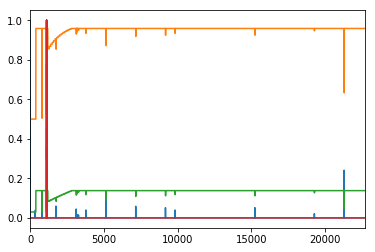

In [56]:
pd.Series(vAnomalyScore).plot()
pd.Series(vLH).plot()
pd.Series(vLogLH).plot()
pd.Series(vFlag).plot()

In [62]:
df = pd.DataFrame.from_records(data)

In [64]:
df.head()

,AnomalyScore,TMactiveCells,TMpredictedCells,flag,idxAS,inputSDR,inputSDRts,inputSDRval,inputTs,inputVal,label,lh,logLH,sp4tm,sp_active
0,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2013-12-02 21:25:00,76.124162,0.0,0.5,0.030103,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7, 17, 95, 145, 147, 162, 164, 178, 185, 189,..."
1,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2013-12-02 21:30:00,78.140707,0.0,0.5,0.030103,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7, 17, 95, 145, 147, 162, 164, 178, 185, 189,..."
2,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2013-12-02 21:35:00,79.329836,0.0,0.5,0.030103,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7, 17, 95, 145, 147, 162, 164, 178, 185, 189,..."
3,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2013-12-02 21:40:00,78.710418,0.0,0.5,0.030103,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7, 17, 95, 145, 147, 162, 164, 178, 185, 189,..."
4,0.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2013-12-02 21:45:00,80.269784,0.0,0.5,0.030103,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7, 17, 95, 145, 147, 162, 164, 178, 185, 189,..."


In [69]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

In [65]:
idcs = df.label[df.label==1].index

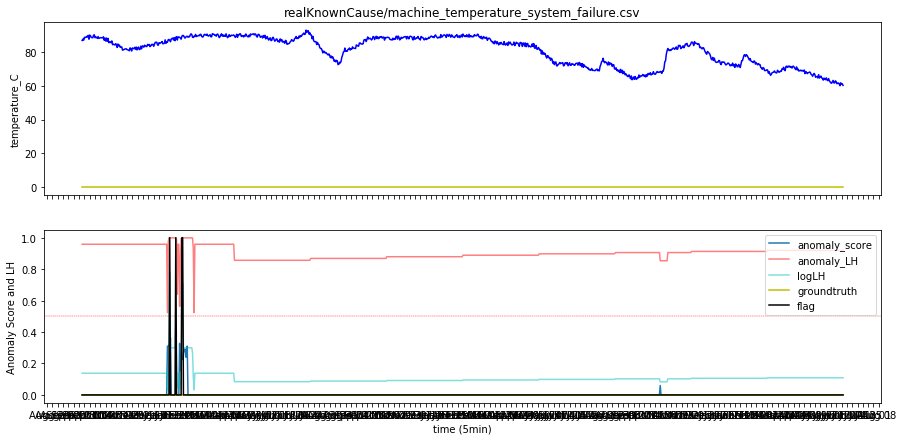

In [88]:
a = 1000
b = 2000

fig, ax = plt.subplots(2, sharex=True, figsize=(15,7))
ax[0].plot(df.inputVal[a:b], color='b')
ax[0].set(ylabel='temperature_C', title=PATH_relative)
#ax[0].vlines(idcs[a:b], 0, 1, transform=ax[0].get_xaxis_transform(), colors='y')
#ax[0].vlines(anomalies_gt, 0, 1, transform=ax[0].get_xaxis_transform(), colors='b', linestyles={'dashed'})
ax[0].plot(df.label[a:b], color='y', label='groundtruth')

ax[1].plot(df.AnomalyScore[a:b], label='anomaly_score')
ax[1].set(ylabel='Anomaly Score and LH')
ax[1].plot(df.lh[a:b], color='r', alpha=0.5, label='anomaly_LH')
ax[1].plot(df.logLH[a:b], color='c', alpha=0.5, label='logLH')
ax[1].axhline(y=0.5, 
              color='r', linestyle='--', linewidth=0.4)
              #xmin=data.anomaly_likelihood.index[a], xmax=data.anomaly_likelihood.index[b])
#ax[1].vlines(idcs[a:b], 0, 1, transform=ax[1].get_xaxis_transform(), alpha=0.9, colors='y', label='groundtruth')
ax[1].plot(df.label[a:b], color='y', label='groundtruth')
ax[1].plot(df.flag[a:b], color='k', label='flag')
ax[1].set(xlabel='time (5min)')
ax[1].legend(loc=1)

#set ticks every week
ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

## Scorer

```
from nab.scorer import Scorer

class Scorer(object):
  """Class used to score a datafile."""

  def __init__(self,
               timestamps,
               predictions,
               labels,
               windowLimits,
               costMatrix,
               probationaryPeriod):
   
    @param predictions   (pandas.Series)   Detector predictions of
                                           whether each record is anomalous or
                                           not. predictions[
                                           0:probationaryPeriod] are ignored.

    @param labels        (pandas.DataFrame) Ground truth for each record.
                                           For each record there should be a 1
                                           or a 0. A 1 implies this record is
                                           within an anomalous window.

    @param windowLimits  (list)            All the window limits in tuple
                                           form: (timestamp start, timestamp
                                           end).

    @param costmatrix    (dict)            Dictionary containing the
                                           cost matrix for this profile.
                                           type:  True positive (tp)
                                                  False positive (fp)
                                                  True Negative (tn)
                                                  False Negative (fn)

    @param probationaryPeriod
                         (int)             Row index after which predictions
                                           are scored.
```

In [92]:
from nab.scorer import scoreCorpus

In [ ]:
score = S

## Save & Load Progress

In [90]:
import copy
dataOut = copy.deepcopy(data)

In [ ]:
# to dump to .json we need to change array to lists and datetime to str

for i in xrange(len(dataOut)):
    for k,v in dataOut[i].items():
        if isinstance(v, np.ndarray):
            #print dataOut[i][k].tolist
            dataOut[i][k] = dataOut[i][k].tolist()
#         if isinstance(v, datetime.datetime):
#             dataOut[i][k] = str(dataOut[i][k])
        else:
            pass

In [89]:
filename = 'univ_swarm_spLearnFalse_tmLearnAll.json'
with open(filename, 'w') as f:
    json.dump(df, f, indent=4, sort_keys=True, separators=(',', ': '))

TypeError:        AnomalyScore                                      TMactiveCells  \
0               1.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1               1.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2               1.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3               0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4               0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5               0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
6               0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
7               0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
8               0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
9               0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
10              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
11              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
12              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
13              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
15              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
16              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
17              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
18              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
19              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
20              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
21              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
23              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
24              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
25              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
26              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
27              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
28              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
29              0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...             ...                                                ...   
22663           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22664           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22665           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22666           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22667           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22668           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22669           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22670           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22671           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22672           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22673           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22674           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22675           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22676           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22677           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22678           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22679           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22680           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22681           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22682           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22683           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22684           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22685           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22686           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22687           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22688           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22689           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22690           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22691           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
22692           0.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        TMpredictedCells  flag  \
0      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
1      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
2      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
3      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
4      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
5      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
6      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
7      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
8      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
9      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
10     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
11     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
12     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
13     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
14     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
15     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
16     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
17     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
18     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
19     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
20     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
21     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
23     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
24     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
25     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
26     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
27     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
28     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
29     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
...                                                  ...   ...   
22663  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22664  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22665  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22666  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22667  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22668  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22669  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22670  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22671  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22672  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22673  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22674  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22675  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22676  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22677  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22678  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22679  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22680  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22681  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22682  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22683  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22684  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22685  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22686  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22687  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22688  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22689  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22690  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22691  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   
22692  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...     0   

                                                   idxAS  \
0      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3                                                     []   
4                                                     []   
5                                                     []   
6                                                     []   
7                                                     []   
8                                                     []   
9                                                     []   
10                                                    []   
11                                                    []   
12                                                    []   
13                                                    []   
14                                                    []   
15                                                    []   
16                                                    []   
17                                                    []   
18                                                    []   
19                                                    []   
20                                                    []   
21                                                    []   
22                                                    []   
23                                                    []   
24                                                    []   
25                                                    []   
26                                                    []   
27                                                    []   
28                                                    []   
29                                                    []   
...                                                  ...   
22663                                                 []   
22664                                                 []   
22665                                                 []   
22666                                                 []   
22667                                                 []   
22668                                                 []   
22669                                                 []   
22670                                                 []   
22671                                                 []   
22672                                                 []   
22673                                                 []   
22674                                                 []   
22675                                                 []   
22676                                                 []   
22677                                                 []   
22678                                                 []   
22679                                                 []   
22680                                                 []   
22681                                                 []   
22682                                                 []   
22683                                                 []   
22684                                                 []   
22685                                                 []   
22686                                                 []   
22687                                                 []   
22688                                                 []   
22689                                                 []   
22690                                                 []   
22691                                                 []   
22692                                                 []   

                                                inputSDR  \
0      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
5      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
6      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
7      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
8      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
9      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
10     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
11     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
12     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
13     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
14     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
15     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
16     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
17     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
18     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
19     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
20     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
21     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
23     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
24     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
25     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
26     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
27     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
28     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
29     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
...                                                  ...   
22663  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22664  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22665  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22666  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22667  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22668  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22669  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22670  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22671  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22672  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22673  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22674  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22675  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22676  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22677  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22678  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22679  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22680  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22681  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22682  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22683  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22684  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22685  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22686  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22687  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22688  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22689  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22690  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22691  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22692  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                              inputSDRts  \
0      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
5      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
6      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
7      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
8      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
9      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
10     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
11     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
12     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
13     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
14     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
15     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
16     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
17     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
18     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
19     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
20     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
21     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
23     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
24     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
25     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
26     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
27     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
28     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
29     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
...                                                  ...   
22663  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22664  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22665  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22666  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22667  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22668  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22669  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22670  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22671  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22672  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22673  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22674  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22675  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22676  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22677  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22678  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22679  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22680  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22681  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22682  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22683  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22684  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22685  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22686  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22687  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22688  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22689  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22690  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22691  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22692  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                             inputSDRval             inputTs  \
0      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 21:25:00   
1      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 21:30:00   
2      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 21:35:00   
3      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 21:40:00   
4      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 21:45:00   
5      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 21:50:00   
6      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 21:55:00   
7      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:00:00   
8      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:05:00   
9      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:10:00   
10     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:15:00   
11     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:20:00   
12     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:25:00   
13     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:30:00   
14     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:35:00   
15     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:40:00   
16     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:45:00   
17     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:50:00   
18     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 22:55:00   
19     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:00:00   
20     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:05:00   
21     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:10:00   
22     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:15:00   
23     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:20:00   
24     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:25:00   
25     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:30:00   
26     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:35:00   
27     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:40:00   
28     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:45:00   
29     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 2013-12-02 23:50:00   
...                                                  ...                 ...   
22663  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:00:00   
22664  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:05:00   
22665  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:10:00   
22666  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:15:00   
22667  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:20:00   
22668  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:25:00   
22669  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:30:00   
22670  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:35:00   
22671  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:40:00   
22672  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:45:00   
22673  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:50:00   
22674  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 13:55:00   
22675  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:00:00   
22676  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:05:00   
22677  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:10:00   
22678  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:15:00   
22679  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:20:00   
22680  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:25:00   
22681  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:30:00   
22682  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:35:00   
22683  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:40:00   
22684  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:45:00   
22685  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:50:00   
22686  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 14:55:00   
22687  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 15:00:00   
22688  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 15:05:00   
22689  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 15:10:00   
22690  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 15:15:00   
22691  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 15:20:00   
22692  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ... 2014-02-19 15:25:00   

        inputVal  label        lh     logLH  \
0      76.124162    0.0  0.500000  0.030103   
1      78.140707    0.0  0.500000  0.030103   
2      79.329836    0.0  0.500000  0.030103   
3      78.710418    0.0  0.500000  0.030103   
4      80.269784    0.0  0.500000  0.030103   
5      80.272828    0.0  0.500000  0.030103   
6      80.353425    0.0  0.500000  0.030103   
7      79.486523    0.0  0.500000  0.030103   
8      80.783277    0.0  0.500000  0.030103   
9      79.508159    0.0  0.500000  0.030103   
10     79.302033    0.0  0.500000  0.030103   
11     80.802624    0.0  0.500000  0.030103   
12     80.377789    0.0  0.500000  0.030103   
13     80.479237    0.0  0.500000  0.030103   
14     81.423560    0.0  0.500000  0.030103   
15     81.373575    0.0  0.500000  0.030103   
16     81.690942    0.0  0.500000  0.030103   
17     80.181250    0.0  0.500000  0.030103   
18     81.767178    0.0  0.500000  0.030103   
19     81.259781    0.0  0.500000  0.030103   
20     80.302937    0.0  0.500000  0.030103   
21     81.114590    0.0  0.500000  0.030103   
22     81.748109    0.0  0.500000  0.030103   
23     81.994607    0.0  0.500000  0.030103   
24     81.258053    0.0  0.500000  0.030103   
25     83.118039    0.0  0.500000  0.030103   
26     81.247021    0.0  0.500000  0.030103   
27     82.735869    0.0  0.500000  0.030103   
28     81.723326    0.0  0.500000  0.030103   
29     81.562356    0.0  0.500000  0.030103   
...          ...    ...       ...       ...   
22663  93.405691    0.0  0.958369  0.138059   
22664  94.124466    0.0  0.958369  0.138059   
22665  93.650855    0.0  0.958369  0.138059   
22666  94.342091    0.0  0.958369  0.138059   
22667  94.617205    0.0  0.958369  0.138059   
22668  94.534074    0.0  0.958369  0.138059   
22669  94.806127    0.0  0.958369  0.138059   
22670  95.553183    0.0  0.958369  0.138059   
22671  94.657280    0.0  0.958369  0.138059   
22672  95.377308    0.0  0.958369  0.138059   
22673  96.820556    0.0  0.958369  0.138059   
22674  94.900900    0.0  0.958369  0.138059   
22675  95.108901    0.0  0.958369  0.138059   
22676  97.184352    0.0  0.958369  0.138059   
22677  95.556043    0.0  0.958369  0.138059   
22678  96.103572    0.0  0.958369  0.138059   
22679  95.961107    0.0  0.958369  0.138059   
22680  97.760870    0.0  0.958369  0.138059   
22681  97.175704    0.0  0.958369  0.138059   
22682  96.768563    0.0  0.958369  0.138059   
22683  96.739868    0.0  0.958369  0.138059   
22684  97.284578    0.0  0.958369  0.138059   
22685  97.549774    0.0  0.958369  0.138059   
22686  98.162952    0.0  0.958369  0.138059   
22687  97.360905    0.0  0.958369  0.138059   
22688  98.185415    0.0  0.958369  0.138059   
22689  97.804168    0.0  0.958369  0.138059   
22690  97.135468    0.0  0.958369  0.138059   
22691  98.056852    0.0  0.958369  0.138059   
22692  96.903861    0.0  0.958369  0.138059   

                                                   sp4tm  \
0      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
5      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
6      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
7      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
8      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
9      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
10     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
11     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
12     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
13     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
14     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
15     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
16     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
17     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
18     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
19     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
20     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
21     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
23     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
24     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
25     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
26     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
27     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
28     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
29     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
...                                                  ...   
22663  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22664  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22665  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22666  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22667  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22668  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22669  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22670  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22671  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22672  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22673  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22674  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22675  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22676  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22677  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22678  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22679  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22680  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22681  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22682  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22683  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22684  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22685  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22686  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22687  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22688  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22689  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22690  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22691  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
22692  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                               sp_active  
0      [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
1      [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
2      [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
3      [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
4      [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
5      [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
6      [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
7      [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
8      [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
9      [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
10     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
11     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
12     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
13     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
14     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
15     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
16     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
17     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
18     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
19     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
20     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
21     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
22     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
23     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
24     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
25     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
26     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
27     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
28     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
29     [7, 17, 95, 145, 147, 162, 164, 178, 185, 189,...  
...                                                  ...  
22663  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22664  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22665  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22666  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22667  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22668  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22669  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22670  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22671  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22672  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22673  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22674  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22675  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22676  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22677  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22678  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22679  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22680  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22681  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22682  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22683  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22684  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22685  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22686  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22687  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22688  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22689  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22690  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22691  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  
22692  [7, 17, 31, 72, 77, 95, 145, 162, 164, 178, 18...  

[22693 rows x 15 columns] is not JSON serializable

In [193]:
# with open(filename, 'r') as f:
#         track = json.load(f)

In [2]:
data[0]

NameError: name 'data' is not defined

# Redirecting Anomaly Score

Once an AS has been outputed, we want to know which are the cells the where unpredicted and causes the error to raise.

-------- 4 -----------  
Raw input vector  
0000010000 0010010000 0   

==== PY Iteration: 56 =====  
Previous learned pattern: array([ 0,  2,  4,  5, 19])  
  
Active cols: [ 5 12 15]  
Inference Active state  
0000000000 0000000000 0  
0000010000 0000010000 0  
0000000000 0010000000 0  
  
Inference Predicted state: [1, 7, 8, 14, 20]  
0000000000 0000000000 0  
0100000110 0000000000 1  
0000000000 0000100000 0  

In [202]:
tm.infPredictedState # [t] predicted to be active next, [t-1] predicted before, for current input 

{'backup': array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=int8), 'candidate': array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=int8), 't': array([[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 1, 

In [203]:
predictedCells = tm.getPredictedState()
print formatRow(predictedCells.max(axis=1).nonzero())

[ 1  7  8 14 20] 


In [198]:
tm.getPredictedState()

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 0]], dtype=int8)

In [207]:
for c in xrange(tm.numberOfCols):
    for i in xrange(tm.cellsPerColumn):
        if not False or tm.infPredictedState['t'][c, i]:
            tm.printCell(c, i, False)

Column 0 Cell 1 : 2 segment(s)
   Seg #0   ID:10    True 0.1785714 (  10/10  )    3 [1,1]1.00 [1,2]0.50 [7,1]1.00 [8,1]1.00 [8,2]0.50 [14,1]0.50 [14,2]1.00 [20,1]1.00
   Seg #1   ID:36    True 0.0178571 (   1/1   )   23 [1,0]0.50 [7,0]0.50 [8,0]0.50 [14,0]0.50 [20,0]0.50
Column 0 Cell 2 : 1 segment(s)
   Seg #0   ID:23    True 0.1964286 (  11/11  )    1 [2,1]1.00 [10,1]1.00 [12,1]1.00 [16,2]1.00 [17,2]1.00 [20,1]1.00
Column 1 Cell 1 : 2 segment(s)
   Seg #0   ID:0     True 0.0178571 (   1/1   )   55
  *Seg #1   ID:31    True 0.1785714 (  10/11  )    4 [5,1]1.00 [12,2]1.00 [15,1]1.00
Column 1 Cell 2 : 1 segment(s)
   Seg #0   ID:5     True 0.0178571 (   1/10  )   54 [1,1]0.50 [7,2]0.50 [8,1]0.50 [14,1]0.50 [20,2]0.50
Column 2 Cell 1 : 3 segment(s)
   Seg #0   ID:11    True 0.1785714 (  10/10  )    3 [1,1]1.00 [1,2]0.50 [7,1]1.00 [8,1]1.00 [8,2]0.50 [14,1]0.50 [14,2]1.00 [20,1]1.00
   Seg #1   ID:17    True 0.1964286 (  11/11  )    2 [0,1]1.00 [2,1]1.00 [6,1]1.00 [11,1]0.50 [11,2]1.00 [1

# Trackability - Feedforward

In [37]:
track

[{'inputSDR': array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
  'inputVal': 73.96732207,
  'sp_active': 0},
 {'inputSDR': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
  'inputVal': 74.93588199999998,
  'sp_active': 2},
 {'inputSDR': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
  'inputVal': 76.12416182,
  'sp_active': 1},
 {'inputSDR': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=uint8),
  'inputVal': 78.14070732,
  'sp_active': 2},
 {'inputSDR': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0], dtype=uint8),
  'inputVal': 79.32983574,
  'sp_active': 3}]

The input SDR can be Decoded up to a certain granularity.

In [38]:
track[0]['inputVal']

73.96732207

In [39]:
vEnc.decode(track[0]['inputSDR'])

({'[70:80]': ([[73.888888888888886, 73.888888888888886]], '73.89')},
 ['[70:80]'])

Feed SP with `sp.compute(track[i]['inputSDR'], learn=True, activeArray=output)`,  
and then the *Temporal Pooler* `inputSDR[track[i]['sp_active']]` = active columns in TM

# Trackability - Backwards

Generate *TM output* by feeding in the active columns of the *SP*.

In [45]:
spSDR[track[0]['sp_active']]

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1])

In [51]:
tm.compute(spSDR[track[0]['sp_active']], enableLearn=True, enableInference=True)

array([ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.], dtype=float32)

In [53]:
# return index for ACTIVE columns in TM: 
tmActive = []

for i in range(tm.infActiveState['t'].shape[0]):
    # assign 1 if any 1 (active cell) in the column,
    # 0 otherwise
    if np.any(tm.infActiveState['t'][i]>0):
        tmActive.append(1)
    else:
        tmActive.append(0)
# return index of active Columns        
tm_active = np.flatnonzero(np.array(tmActive))
del(tmActive) # delete list

In [48]:
tm_active

array([ 1,  7,  8, 14, 20])

Build `spSDR[track[0]['sp_active']]` back:

In [44]:
sp_active = np.zeros_like(spSDR[0])
sp_active[tm_active] = 1
sp_active

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1])

Find the corresponding column in spSDR:

In [404]:
idx = []
for _ in spSDR:
    i =+ 1
    if np.array_equal(sp_active, spSDR[_]) == True:
        idx.append(i)
print "matching spSDR:", idx

matching spSDR: [1]


In [405]:
# calculate with which inputSDR, the active SP col has the higher overlap: 


for j in idx:
    overlap = []
    for i in xrange(len(track)):
        overlap.append(sum(track[i]['inputSDR'] * spSDR[j]))
        o = last_max_index(overlap)
        
    print "overlap: ", str(overlap) +  "\nInputSDR[idx]: ", str(o)
    print "inputSDR: ", str(track[o]['inputSDR'])

overlap:  [0, 1, 2, 1, 0]
InputSDR[idx]:  2
inputSDR:  [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0]


This function should be useful in case we have ties in the overlap-score.

In [408]:
def match_back_SP_to_SDR(lista):
    '''
    This fnc returns the indeces of the InputSDR/s that match 
    (have the highest overalpping score) the current SP the most.
    
    input:  copy of a list `list[:]` with the overlap score bw. 
            the winning spSDR[i] and the inputSDR[0:]   
    output: 'match', a list, indeces of InputSDR in `track`
    '''
    
    a = max(lista)
    b = a
    match = []
    count = 0

    while b == a:
        i = lista.index(b)
        out = lista.pop(i)
        i = i+count  # fill the indexes popped out
        match.append(i)
        count += 1
        b = max(lista)    
    
    return match

In [409]:
match_back_SP_to_SDR(overlap[:])

[2]

In [410]:
for i in match_back_SP_to_SDR(overlap[:]):
    print "inputVal[" + str(i) + "]: " + str(track[i]['inputVal'])
    print "De-Encoder: " + str(vEnc.decode(track[i]['inputSDR']))
    print "-------"

inputVal[2]: 76.12416182
De-Encoder: ({'[70:80]': ([[76.111111111111114, 76.111111111111114]], '76.11')}, ['[70:80]'])
-------


# Dataset Helpers

In [38]:
from pkg_resources import resource_filename

datasetPath = resource_filename("nupic.datafiles", "extra/hotgym/hotgym.csv")
print datasetPath

with open(datasetPath) as inputFile:
    print
    for _ in xrange(8):
        print inputFile.next().strip()

/Users/mleborgne/_git/nupic/src/nupic/datafiles/extra/hotgym/hotgym.csv

gym,address,timestamp,consumption
string,string,datetime,float
S,,T,
Balgowlah Platinum,Shop 67 197-215 Condamine Street Balgowlah 2093,2010-07-02 00:00:00.0,5.3
Balgowlah Platinum,Shop 67 197-215 Condamine Street Balgowlah 2093,2010-07-02 00:15:00.0,5.5
Balgowlah Platinum,Shop 67 197-215 Condamine Street Balgowlah 2093,2010-07-02 00:30:00.0,5.1
Balgowlah Platinum,Shop 67 197-215 Condamine Street Balgowlah 2093,2010-07-02 00:45:00.0,5.3
Balgowlah Platinum,Shop 67 197-215 Condamine Street Balgowlah 2093,2010-07-02 01:00:00.0,5.2


# Loading Data

`FileRecordStream` - file reader for the NuPIC file format (CSV with three header rows, understands datetimes)

In [39]:
from nupic.data.file_record_stream import FileRecordStream

def getData():
    return FileRecordStream(datasetPath)

data = getData()
for _ in xrange(5):
    print data.next()

['Balgowlah Platinum', 'Shop 67 197-215 Condamine Street Balgowlah 2093', datetime.datetime(2010, 7, 2, 0, 0), 5.3]
['Balgowlah Platinum', 'Shop 67 197-215 Condamine Street Balgowlah 2093', datetime.datetime(2010, 7, 2, 0, 15), 5.5]
['Balgowlah Platinum', 'Shop 67 197-215 Condamine Street Balgowlah 2093', datetime.datetime(2010, 7, 2, 0, 30), 5.1]
['Balgowlah Platinum', 'Shop 67 197-215 Condamine Street Balgowlah 2093', datetime.datetime(2010, 7, 2, 0, 45), 5.3]
['Balgowlah Platinum', 'Shop 67 197-215 Condamine Street Balgowlah 2093', datetime.datetime(2010, 7, 2, 1, 0), 5.2]


In [40]:
from nupic.frameworks.opf.model_factory import ModelFactory
model = ModelFactory.create(MODEL_PARAMS)
model.enableInference({'predictedField': 'consumption'})

In [41]:
data = getData()
for _ in xrange(100):
    record = dict(zip(data.getFieldNames(), data.next()))
    print "input: ", record["consumption"]
    result = model.run(record)
    print "prediction: ", result.inferences["multiStepBestPredictions"][1]

input:  5.3
prediction:  5.3
input:  5.5
prediction:  5.5
input:  5.1
prediction:  5.36
input:  5.3
prediction:  5.1
input:  5.2
prediction:  5.342
input:  5.5
prediction:  5.2994
input:  4.5
prediction:  5.35958
input:  1.2
prediction:  4.92
input:  1.1
prediction:  1.2
input:  1.2
prediction:  1.17
input:  1.2
prediction:  1.179
input:  1.2
prediction:  1.1853
input:  1.2
prediction:  1.18971
input:  1.2
prediction:  1.192797
input:  1.1
prediction:  1.1949579
input:  1.2
prediction:  1.16647053
input:  1.1
prediction:  1.176529371
input:  1.2
prediction:  1.1535705597
input:  1.2
prediction:  1.16749939179
input:  1.1
prediction:  1.17724957425
input:  1.2
prediction:  1.15407470198
input:  6.0
prediction:  1.16785229138
input:  7.9
prediction:  5.551706
input:  8.4
prediction:  6.2561942
input:  10.6
prediction:  6.89933594
input:  12.4
prediction:  10.6
input:  12.1
prediction:  12.4
input:  12.4
prediction:  12.31
input:  11.4
prediction:  12.337
input:  11.2
prediction:  10.84
i

In [42]:
print "5-step prediction: ", result.inferences["multiStepBestPredictions"][5]

5-step prediction:  1.19932370691


# Anomaly Score

In [43]:
# Model Params!
MODEL_PARAMS = {
    # Type of model that the rest of these parameters apply to.
    'model': "HTMPrediction",

    # Version that specifies the format of the config.
    'version': 1,

    # Intermediate variables used to compute fields in modelParams and also
    # referenced from the control section.
    'aggregationInfo': {   'days': 0,
        'fields': [('consumption', 'sum')],
        'hours': 1,
        'microseconds': 0,
        'milliseconds': 0,
        'minutes': 0,
        'months': 0,
        'seconds': 0,
        'weeks': 0,
        'years': 0},

    'predictAheadTime': None,

    # Model parameter dictionary.
    'modelParams': {
        # The type of inference that this model will perform
        'inferenceType': 'TemporalAnomaly',

        'sensorParams': {
            # Sensor diagnostic output verbosity control;
            # if > 0: sensor region will print out on screen what it's sensing
            # at each step 0: silent; >=1: some info; >=2: more info;
            # >=3: even more info (see compute() in py/regions/RecordSensor.py)
            'verbosity' : 0,

            # Include the encoders we use
            'encoders': {
                u'timestamp_timeOfDay': {
                    'fieldname': u'timestamp',
                    'name': u'timestamp_timeOfDay',
                    'timeOfDay': (21, 0.5),
                    'type': 'DateEncoder'},
                u'timestamp_dayOfWeek': None,
                u'timestamp_weekend': None,
                u'consumption': {
                    'clipInput': True,
                    'fieldname': u'consumption',
                    'maxval': 100.0,
                    'minval': 0.0,
                    'n': 50,
                    'name': u'c1',
                    'type': 'ScalarEncoder',
                    'w': 21},},

            # A dictionary specifying the period for automatically-generated
            # resets from a RecordSensor;
            #
            # None = disable automatically-generated resets (also disabled if
            # all of the specified values evaluate to 0).
            # Valid keys is the desired combination of the following:
            #   days, hours, minutes, seconds, milliseconds, microseconds, weeks
            #
            # Example for 1.5 days: sensorAutoReset = dict(days=1,hours=12),
            #
            # (value generated from SENSOR_AUTO_RESET)
            'sensorAutoReset' : None,
        },

        'spEnable': True,

        'spParams': {
            # SP diagnostic output verbosity control;
            # 0: silent; >=1: some info; >=2: more info;
            'spVerbosity' : 0,

            # Spatial Pooler implementation selector, see getSPClass
            # in py/regions/SPRegion.py for details
            # 'py' (default), 'cpp' (speed optimized, new)
            'spatialImp' : 'cpp',

            'globalInhibition': 1,

            # Number of cell columns in the cortical region (same number for
            # SP and TM)
            # (see also tpNCellsPerCol)
            'columnCount': 2048,

            'inputWidth': 0,

            # SP inhibition control (absolute value);
            # Maximum number of active columns in the SP region's output (when
            # there are more, the weaker ones are suppressed)
            'numActiveColumnsPerInhArea': 40,

            'seed': 1956,

            # potentialPct
            # What percent of the columns's receptive field is available
            # for potential synapses. At initialization time, we will
            # choose potentialPct * (2*potentialRadius+1)^2
            'potentialPct': 0.5,

            # The default connected threshold. Any synapse whose
            # permanence value is above the connected threshold is
            # a "connected synapse", meaning it can contribute to the
            # cell's firing. Typical value is 0.10. Cells whose activity
            # level before inhibition falls below minDutyCycleBeforeInh
            # will have their own internal synPermConnectedCell
            # threshold set below this default value.
            # (This concept applies to both SP and TM and so 'cells'
            # is correct here as opposed to 'columns')
            'synPermConnected': 0.1,

            'synPermActiveInc': 0.1,

            'synPermInactiveDec': 0.005,
        },

        # Controls whether TM is enabled or disabled;
        # TM is necessary for making temporal predictions, such as predicting
        # the next inputs.  Without TP, the model is only capable of
        # reconstructing missing sensor inputs (via SP).
        'tmEnable' : True,

        'tmParams': {
            # TM diagnostic output verbosity control;
            # 0: silent; [1..6]: increasing levels of verbosity
            # (see verbosity in nupic/trunk/py/nupic/research/TP.py and BacktrackingTMCPP.py)
            'verbosity': 0,

            # Number of cell columns in the cortical region (same number for
            # SP and TM)
            # (see also tpNCellsPerCol)
            'columnCount': 2048,

            # The number of cells (i.e., states), allocated per column.
            'cellsPerColumn': 32,

            'inputWidth': 2048,

            'seed': 1960,

            # Temporal Pooler implementation selector (see _getTPClass in
            # CLARegion.py).
            'temporalImp': 'cpp',

            # New Synapse formation count
            # NOTE: If None, use spNumActivePerInhArea
            #
            # TODO: need better explanation
            'newSynapseCount': 20,

            # Maximum number of synapses per segment
            #  > 0 for fixed-size CLA
            # -1 for non-fixed-size CLA
            #
            # TODO: for Ron: once the appropriate value is placed in TP
            # constructor, see if we should eliminate this parameter from
            # description.py.
            'maxSynapsesPerSegment': 32,

            # Maximum number of segments per cell
            #  > 0 for fixed-size CLA
            # -1 for non-fixed-size CLA
            #
            # TODO: for Ron: once the appropriate value is placed in TP
            # constructor, see if we should eliminate this parameter from
            # description.py.
            'maxSegmentsPerCell': 128,

            # Initial Permanence
            # TODO: need better explanation
            'initialPerm': 0.21,

            # Permanence Increment
            'permanenceInc': 0.1,

            # Permanence Decrement
            # If set to None, will automatically default to tpPermanenceInc
            # value.
            'permanenceDec' : 0.1,

            'globalDecay': 0.0,

            'maxAge': 0,

            # Minimum number of active synapses for a segment to be considered
            # during search for the best-matching segments.
            # None=use default
            # Replaces: tpMinThreshold
            'minThreshold': 9,

            # Segment activation threshold.
            # A segment is active if it has >= tpSegmentActivationThreshold
            # connected synapses that are active due to infActiveState
            # None=use default
            # Replaces: tpActivationThreshold
            'activationThreshold': 12,

            'outputType': 'normal',

            # "Pay Attention Mode" length. This tells the TM how many new
            # elements to append to the end of a learned sequence at a time.
            # Smaller values are better for datasets with short sequences,
            # higher values are better for datasets with long sequences.
            'pamLength': 1,
        },

        'clParams': {
            'regionName' : 'SDRClassifierRegion',

            # Classifier diagnostic output verbosity control;
            # 0: silent; [1..6]: increasing levels of verbosity
            'verbosity' : 0,

            # This controls how fast the classifier learns/forgets. Higher values
            # make it adapt faster and forget older patterns faster.
            'alpha': 0.005,

            # This is set after the call to updateConfigFromSubConfig and is
            # computed from the aggregationInfo and predictAheadTime.
            'steps': '1',

            'implementation': 'cpp',
        },

        'anomalyParams': {
            u'anomalyCacheRecords': None,
            u'autoDetectThreshold': None,
            u'autoDetectWaitRecords': 2184
        },

        'trainSPNetOnlyIfRequested': False,
    },
}

In [44]:
from nupic.frameworks.opf.model_factory import ModelFactory
model = ModelFactory.create(MODEL_PARAMS)
model.enableInference({'predictedField': 'consumption'})

In [45]:
data = getData()
for _ in xrange(5):
    record = dict(zip(data.getFieldNames(), data.next()))
    print "input: ", record["consumption"]
    result = model.run(record)
    print "prediction: ", result.inferences["multiStepBestPredictions"][1]

input:  5.3
prediction:  5.3
input:  5.5
prediction:  5.5
input:  5.1
prediction:  5.36
input:  5.3
prediction:  5.1
input:  5.2
prediction:  5.342


In [46]:
print result

ModelResult(	predictionNumber=4
	rawInput={'timestamp': datetime.datetime(2010, 7, 2, 1, 0), 'gym': 'Balgowlah Platinum', 'consumption': 5.2, 'address': 'Shop 67 197-215 Condamine Street Balgowlah 2093'}
	sensorInput=SensorInput(	dataRow=(5.2, 1.0)
	dataDict={'timestamp': datetime.datetime(2010, 7, 2, 1, 0), 'gym': 'Balgowlah Platinum', 'consumption': 5.2, 'address': 'Shop 67 197-215 Condamine Street Balgowlah 2093'}
	dataEncodings=[array([ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32), array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)]
	sequenceReset=0.0
	category=-1
)
	inferences={'multiStepPredictions': {1: {5.1: 0.0088801263517415546, 5.2: 0.010775254623541418, 5.341999999999999: 0.98034461902471692}}, 'multiStepBucketLikelihoods': {1: {1

In [47]:
print "anomaly score: ", result.inferences["anomalyScore"]

anomaly score:  0.4


__See Subutai's talk for more info on anomaly detection!__

# Built-in OPF Clients

`python examples/opf/bin/OpfRunExperiment.py examples/opf/experiments/multistep/hotgym/`

Outputs `examples/opf/experiments/multistep/hotgym/inference/DefaultTask.TemporalMultiStep.predictionLog.csv`

`python bin/run_swarm.py examples/opf/experiments/multistep/hotgym/permutations.py`

Outputs `examples/opf/experiments/multistep/hotgym/model_0/description.py`